# Annalyse non supervisée

## Chargement des features

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

df_features = pd.read_parquet("../data/brain_features_resnet18.parquet")
df_features.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,label_num
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.223682,0.710136,1.481257,0.459431,0.692085,0.185364,2.059628,...,1.406707,0.216484,1.110025,1.869285,0.236830,0.708141,0.785015,0.015425,0.529030,1
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,2.303200,1.045277,1.294456,2.547840,0.545068,0.133437,1.212342,...,0.605513,2.760418,0.387895,1.810046,1.444754,0.330206,1.192759,0.032950,0.648934,1
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,3.997212,1.404900,1.149433,0.966352,1.491258,0.024406,1.677062,...,1.358088,2.565499,0.517149,2.708174,2.859923,0.957908,1.831673,0.093461,0.461350,1
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,2.034307,1.851072,1.561280,0.760116,0.673758,0.079369,3.240707,...,0.254960,3.330342,1.184569,0.911555,1.283250,0.122348,0.274706,0.959745,1.228101,1
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,2.823692,1.664199,1.330548,1.195984,2.489143,0.071206,2.423799,...,0.000000,1.554175,0.503567,0.093622,0.379601,1.066818,1.798177,0.003183,1.693390,1


### Récupération des colonnes de features

In [9]:
feature_cols = [c for c in df_features.columns if c.startswith("f_")]
X = df_features[feature_cols].values  # shape (1500, 512)

print(X.shape)

(1506, 512)


## Standardisation & PCA

In [12]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA pour réduire à 50 dims (KMeans + visualisation)
pca_50 = PCA(n_components=50, random_state=42)
X_pca50 = pca_50.fit_transform(X_scaled)

print("Variance expliquée (50 comps) :", pca_50.explained_variance_ratio_.sum())

Variance expliquée (50 comps) : 0.7158737


La PCA à 50 composantes conserve environ 71.6%

## KMeans (clustering principal)

### Essai de plusieurs valeurs de k

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

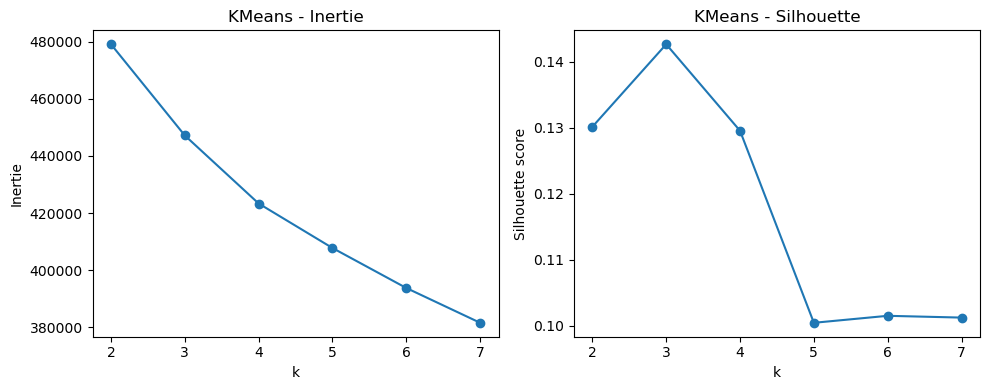

In [17]:
inertias = []
sil_scores = []
K_RANGE = range(2, 8)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_pca50)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_pca50, labels_k))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title("KMeans - Inertie")

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("KMeans - Silhouette")
plt.tight_layout()
plt.show()

### Fit final avec k choisi

In [20]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca50)

df_features["cluster_kmeans"] = clusters
df_features["cluster_kmeans"].value_counts()

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


cluster_kmeans
0    815
1    691
Name: count, dtype: int64

## Visualisation 2D

### PCA à 2 composants pour les scatters plots

In [24]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_scaled)

df_features["pc1"] = X_pca2[:,0]
df_features["pc2"] = X_pca2[:,1]

### Scatter coloré par cluster

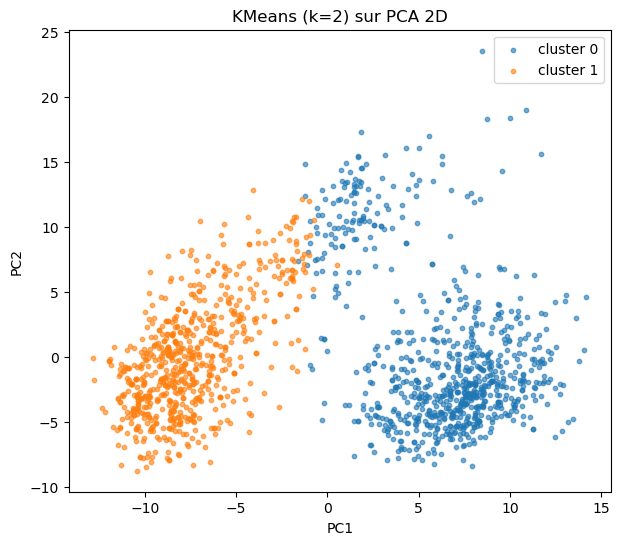

In [27]:
plt.figure(figsize=(7,6))
for c in sorted(df_features["cluster_kmeans"].unique()):
    subset = df_features[df_features["cluster_kmeans"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=10, alpha=0.6, label=f"cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans (k=2) sur PCA 2D")
plt.legend()
plt.show()

### Scatter coloré par label (images annotées)

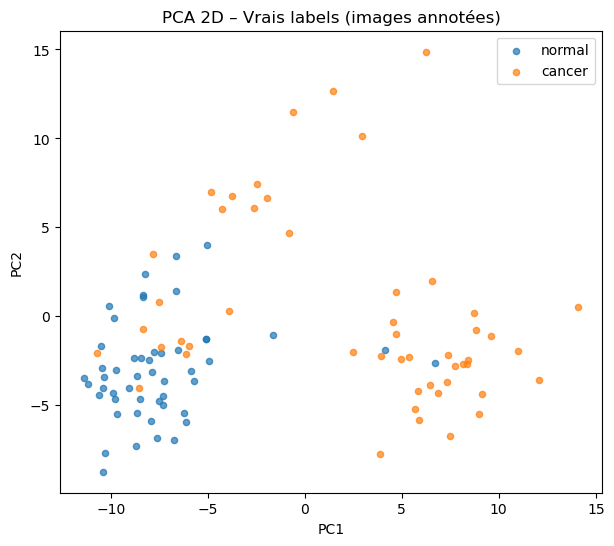

In [30]:
labeled = df_features[df_features["label"].notna()]

plt.figure(figsize=(7,6))
for lab in ["normal", "cancer"]:
    subset = labeled[labeled["label"] == lab]
    plt.scatter(subset["pc1"], subset["pc2"], s=20, alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D – Vrais labels (images annotées)")
plt.legend()
plt.show()

## Evaluation des clusters avec les labels connus

Evaluation du KMeans sur sous-ensemble

In [33]:
labeled = df_features[df_features["label"].notna()].copy()

y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster = labeled["cluster_kmeans"].values

print("ARI :", adjusted_rand_score(y_true, y_cluster))
print("NMI :", normalized_mutual_info_score(y_true, y_cluster))
print("Silhouette (global) :", silhouette_score(X_pca50, df_features["cluster_kmeans"]))

ARI : 0.40405226838937014
NMI : 0.3802435393427011
Silhouette (global) : 0.13015531


Matrice de confusion

In [37]:
cm = confusion_matrix(y_true, y_cluster)
cm

array([[ 2, 48],
       [34, 16]], dtype=int64)

In [ ]:
# afficher avec seaborn

## Test d'un autres modèle de clustering

In [40]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
clusters_db = dbscan.fit_predict(X_pca50)

df_features["cluster_dbscan"] = clusters_db
df_features["cluster_dbscan"].value_counts()

cluster_dbscan
-1    1506
Name: count, dtype: int64

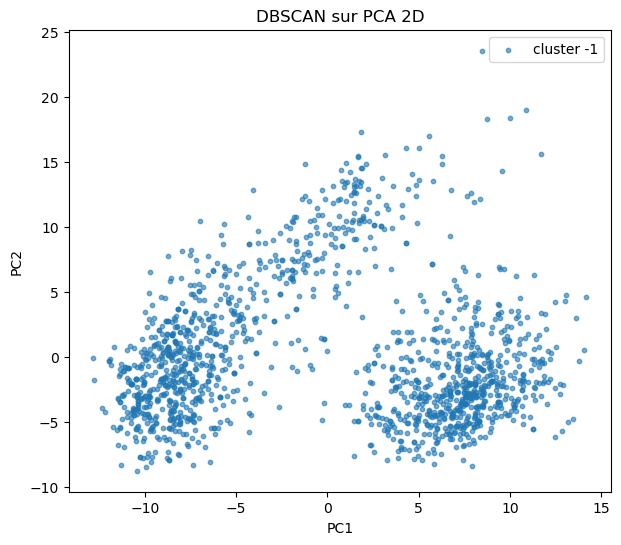

In [42]:
plt.figure(figsize=(7,6))
for c in sorted(df_features["cluster_dbscan"].unique()):
    subset = df_features[df_features["cluster_dbscan"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=10, alpha=0.6, label=f"cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN sur PCA 2D")
plt.legend()
plt.show()

Synthèse des résultats du clustering

L’extraction des features via ResNet18 suivie d’une PCA (50 composantes, ~71 % de variance expliquée) a permis d’explorer la structure latente du dataset.

L’algorithme KMeans montre :

un optimum de Silhouette autour de k=3 (≈0.145)

une structure exploitable en k=2, cohérente avec les deux classes réelles

deux groupes visibles sur la PCA 2D

L’évaluation du clustering par rapport aux labels connus donne :

ARI = 0.404

NMI = 0.380

une matrice de confusion montrant une corrélation non triviale entre clusters et classes réelles

Cela montre que :

les embeddings contiennent bien de l’information discriminante sur les tumeurs

mais la séparation n’est pas suffisante pour une classification directe

L’algorithme DBSCAN ne détecte aucun cluster significatif (tout en bruit), confirmant que la structure n’est pas suffisamment dense pour une approche à seuils fixes.

Conclusion

Les résultats indiquent que le clustering seul est insuffisant pour séparer correctement les classes normal / cancer.
Cependant, la structure latente révélée par KMeans est suffisamment informative pour justifier une approche semi-supervisée, qui exploitera simultanément les 100 labels disponibles et les 1400 images non annotées.